In [41]:
import pandas as pd
import numpy as np
import scipy
import librosa
import time
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from spafe.features.gfcc import gfcc
from spafe.features.lfcc import lfcc
from spafe.features.mfcc import mfcc
from spafe.features.rplp import rplp
from spafe.features.lpc import lpc

In [3]:
# lese db_snapshot ein
df = pd.read_csv("data/db_data/db_snapshot.csv")
df.head()

,Unnamed: 0,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de,confidence,min_conf,current_location,active_status
0,0,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:10.500000,0 days 00:00:13.500000,Dorngrasmücke,0.911344,0.85,0101000020E6100000000000A0F7A81F40000000C0FA2A...,False
1,1,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:12,0 days 00:00:15,Dorngrasmücke,0.907262,0.85,0101000020E6100000000000A0F7A81F40000000C0FA2A...,False
2,2,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:04.500000,0 days 00:00:07.500000,Dorngrasmücke,0.920276,0.85,0101000020E6100000000000A0F7A81F40000000C0FA2A...,False
3,3,2022-02-23 10:16:33.368821,0 days 00:00:14.097067,3221692,3221692_1645611393-368821.flac,0 days 00:00:01.500000,0 days 00:00:04.500000,Dorngrasmücke,0.976985,0.85,0101000020E6100000000000A0B2A81F4000000060F72A...,True
4,4,2022-02-23 10:16:33.368821,0 days 00:00:14.097067,3221692,3221692_1645611393-368821.flac,0 days 00:00:00,0 days 00:00:03,Dorngrasmücke,0.984349,0.85,0101000020E6100000000000A0B2A81F4000000060F72A...,True


In [4]:
# remove unneeded columns
df.drop(['Unnamed: 0', 'current_location', 'active_status', 'confidence', 'min_conf'], axis=1, inplace=True)
print(df.shape)
df.head()

(129, 7)


,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de
0,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:10.500000,0 days 00:00:13.500000,Dorngrasmücke
1,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:12,0 days 00:00:15,Dorngrasmücke
2,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:04.500000,0 days 00:00:07.500000,Dorngrasmücke
3,2022-02-23 10:16:33.368821,0 days 00:00:14.097067,3221692,3221692_1645611393-368821.flac,0 days 00:00:01.500000,0 days 00:00:04.500000,Dorngrasmücke
4,2022-02-23 10:16:33.368821,0 days 00:00:14.097067,3221692,3221692_1645611393-368821.flac,0 days 00:00:00,0 days 00:00:03,Dorngrasmücke


In [5]:
# filter out duplicates
df = df.drop_duplicates()
print(df.shape)
df.head()

(128, 7)


,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de
0,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:10.500000,0 days 00:00:13.500000,Dorngrasmücke
1,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:12,0 days 00:00:15,Dorngrasmücke
2,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:04.500000,0 days 00:00:07.500000,Dorngrasmücke
3,2022-02-23 10:16:33.368821,0 days 00:00:14.097067,3221692,3221692_1645611393-368821.flac,0 days 00:00:01.500000,0 days 00:00:04.500000,Dorngrasmücke
4,2022-02-23 10:16:33.368821,0 days 00:00:14.097067,3221692,3221692_1645611393-368821.flac,0 days 00:00:00,0 days 00:00:03,Dorngrasmücke


In [6]:
# create dataframes based on species as we do not compare different species, only within the species

df_dorngras = df[df['species_name_de'].str.contains('Dorngrasmücke')]
df_trauer = df[df['species_name_de'].str.contains('Trauerschnäpper')]
df_grau = df[df['species_name_de'].str.contains('Grauschnäpper')]
df_gold = df[df['species_name_de'].str.contains('Goldammer')]
df_blut = df[df['species_name_de'].str.contains('Bluthänfling')]


In [7]:
print(f"Dorngrasmücke: {df_dorngras.shape}")
print(f"Trauerschnäpper: {df_trauer.shape}")
print(f"Grauschnäpper: {df_grau.shape}")
print(f"Goldammer: {df_gold.shape}")
print(f"Bluthänfling: {df_blut.shape}")

Dorngrasmücke: (14, 7)
Trauerschnäpper: (19, 7)
Grauschnäpper: (77, 7)
Goldammer: (6, 7)
Bluthänfling: (12, 7)


In [8]:
df_trauer.head(20)


,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de
13,2022-02-23 10:12:04.393265,0 days 00:00:13.960533,3220764,3220764_1645611124-393265.flac,0 days 00:00:06,0 days 00:00:09,Trauerschnäpper
14,2022-02-23 10:12:04.393265,0 days 00:00:13.960533,3220764,3220764_1645611124-393265.flac,0 days 00:00:03,0 days 00:00:06,Trauerschnäpper
15,2022-02-23 10:12:04.393265,0 days 00:00:13.960533,3220764,3220764_1645611124-393265.flac,0 days 00:00:04.500000,0 days 00:00:07.500000,Trauerschnäpper
16,2022-02-23 10:11:47.158217,0 days 00:00:13.994667,13429496,13429496_1645611107-158217.flac,0 days 00:00:00,0 days 00:00:03,Trauerschnäpper
17,2022-02-23 10:11:47.158217,0 days 00:00:13.994667,13429496,13429496_1645611107-158217.flac,0 days 00:00:03,0 days 00:00:06,Trauerschnäpper
18,2022-02-23 10:11:29.790718,0 days 00:00:14.062933,6030536,6030536_1645611089-790718.flac,0 days 00:00:00,0 days 00:00:03,Trauerschnäpper
19,2022-02-23 10:11:28.871241,0 days 00:00:14.131200,6031380,6031380_1645611088-871241.flac,0 days 00:00:01.500000,0 days 00:00:04.500000,Trauerschnäpper
20,2022-02-23 10:11:28.871241,0 days 00:00:14.131200,6031380,6031380_1645611088-871241.flac,0 days 00:00:00,0 days 00:00:03,Trauerschnäpper
21,2022-02-23 10:11:18.557196,0 days 00:00:13.994667,3221664,3221664_1645611078-557196.flac,0 days 00:00:07.500000,0 days 00:00:10.500000,Trauerschnäpper
22,2022-02-23 10:11:18.557196,0 days 00:00:13.994667,3221664,3221664_1645611078-557196.flac,0 days 00:00:12,0 days 00:00:15,Trauerschnäpper


In [9]:
# Trauerschnäpper: Put same call detected by multiple boards in one group
df_trauer_1_1 = df_trauer.loc[[118, 119]]  # 938song or 279song, probably the latter,  2 nodes          938song
df_trauer_2_1 = df_trauer.loc[24:29]       # probably 938song,                         2 nodes          938song
df_trauer_2_2 = df_trauer.loc[18:23]       # probably 279song,                         4 nodes          279song
df_trauer_2_3 = df_trauer.loc[[16, 17]]    # probably 892call,                         only one node
df_trauer_2_4 = df_trauer.loc[13:15]       # probably 383call,                         only one node

# TODO 11:11 differentiate between song and call, as they are temporally close

In [10]:
df_trauer_2_2.head(10)

,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de
18,2022-02-23 10:11:29.790718,0 days 00:00:14.062933,6030536,6030536_1645611089-790718.flac,0 days 00:00:00,0 days 00:00:03,Trauerschnäpper
19,2022-02-23 10:11:28.871241,0 days 00:00:14.131200,6031380,6031380_1645611088-871241.flac,0 days 00:00:01.500000,0 days 00:00:04.500000,Trauerschnäpper
20,2022-02-23 10:11:28.871241,0 days 00:00:14.131200,6031380,6031380_1645611088-871241.flac,0 days 00:00:00,0 days 00:00:03,Trauerschnäpper
21,2022-02-23 10:11:18.557196,0 days 00:00:13.994667,3221664,3221664_1645611078-557196.flac,0 days 00:00:07.500000,0 days 00:00:10.500000,Trauerschnäpper
22,2022-02-23 10:11:18.557196,0 days 00:00:13.994667,3221664,3221664_1645611078-557196.flac,0 days 00:00:12,0 days 00:00:15,Trauerschnäpper
23,2022-02-23 10:11:13.147232,0 days 00:00:14.062933,7511104,7511104_1645611073-147232.flac,0 days 00:00:09,0 days 00:00:12,Trauerschnäpper


In [11]:
df_blut.head(15)

,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de
94,2022-02-23 10:03:04.083249,0 days 00:00:14.028800,3220764,3220764_1645610584-83249.flac,0 days 00:00:06,0 days 00:00:09,Bluthänfling
97,2022-02-23 10:02:34.063155,0 days 00:00:14.097067,3220764,3220764_1645610554-63155.flac,0 days 00:00:01.500000,0 days 00:00:04.500000,Bluthänfling
98,2022-02-23 10:02:34.063155,0 days 00:00:14.097067,3220764,3220764_1645610554-63155.flac,0 days 00:00:06,0 days 00:00:09,Bluthänfling
99,2022-02-23 10:02:34.063155,0 days 00:00:14.097067,3220764,3220764_1645610554-63155.flac,0 days 00:00:03,0 days 00:00:06,Bluthänfling
121,2022-02-23 09:35:03.023211,0 days 00:00:14.028800,3220764,3220764_1645608903-23211.flac,0 days 00:00:07.500000,0 days 00:00:10.500000,Bluthänfling
122,2022-02-23 09:35:03.023211,0 days 00:00:14.028800,3220764,3220764_1645608903-23211.flac,0 days 00:00:06,0 days 00:00:09,Bluthänfling
123,2022-02-23 09:34:02.983219,0 days 00:00:14.062933,3220764,3220764_1645608842-983219.flac,0 days 00:00:00,0 days 00:00:03,Bluthänfling
124,2022-02-23 09:31:35.573393,0 days 00:00:14.165333,13429552,13429552_1645608695-573393.flac,0 days 00:00:01.500000,0 days 00:00:04.500000,Bluthänfling
125,2022-02-23 09:31:35.573393,0 days 00:00:14.165333,13429552,13429552_1645608695-573393.flac,0 days 00:00:09,0 days 00:00:12,Bluthänfling
126,2022-02-23 09:31:35.573393,0 days 00:00:14.165333,13429552,13429552_1645608695-573393.flac,0 days 00:00:07.500000,0 days 00:00:10.500000,Bluthänfling


In [12]:
# Bluthänfling
df_blut_1_1 = df_blut.loc[124:]      # 660song,           1 node            660song passt
df_blut_1_2 = df_blut.loc[[123]]     # maybe 592call,     1 node            592call oder 004call, nicht unterscheidbar
df_blut_1_3 = df_blut.loc[121:122]   # maybe 004call,     1 node            004call
df_blut_2_1 = df_blut.loc[97:99]     # maybe 660song,     1 node
df_blut_2_2 = df_blut.loc[[94]]      # maybe 592call,     1 node

In [13]:
df_dorngras.head(15)

,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de
0,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:10.500000,0 days 00:00:13.500000,Dorngrasmücke
1,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:12,0 days 00:00:15,Dorngrasmücke
2,2022-02-23 10:19:30.140225,0 days 00:00:14.028800,6030536,6030536_1645611570-140225.flac,0 days 00:00:04.500000,0 days 00:00:07.500000,Dorngrasmücke
3,2022-02-23 10:16:33.368821,0 days 00:00:14.097067,3221692,3221692_1645611393-368821.flac,0 days 00:00:01.500000,0 days 00:00:04.500000,Dorngrasmücke
4,2022-02-23 10:16:33.368821,0 days 00:00:14.097067,3221692,3221692_1645611393-368821.flac,0 days 00:00:00,0 days 00:00:03,Dorngrasmücke
5,2022-02-23 10:16:30.000177,0 days 00:00:14.165333,6030536,6030536_1645611390-177.flac,0 days 00:00:04.500000,0 days 00:00:07.500000,Dorngrasmücke
6,2022-02-23 10:16:30.000177,0 days 00:00:14.165333,6030536,6030536_1645611390-177.flac,0 days 00:00:03,0 days 00:00:06,Dorngrasmücke
7,2022-02-23 10:16:30.000177,0 days 00:00:14.165333,6030536,6030536_1645611390-177.flac,0 days 00:00:00,0 days 00:00:03,Dorngrasmücke
8,2022-02-23 10:16:14.984882,0 days 00:00:14.165333,6030536,6030536_1645611374-984882.flac,0 days 00:00:04.500000,0 days 00:00:07.500000,Dorngrasmücke
9,2022-02-23 10:16:14.984882,0 days 00:00:14.165333,6030536,6030536_1645611374-984882.flac,0 days 00:00:10.500000,0 days 00:00:13.500000,Dorngrasmücke


In [14]:
# TODO Problem: timestamps in dataframe don't match noted timestamps in deployment
#      Solution: use audios from different location (maybe ask Tom)

In [15]:
df_gold.head(10)

,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de
36,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:10.500000,0 days 00:00:13.500000,Goldammer
37,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:12,0 days 00:00:15,Goldammer
38,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:06,0 days 00:00:09,Goldammer
39,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:07.500000,0 days 00:00:10.500000,Goldammer
40,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:09,0 days 00:00:12,Goldammer
120,2022-02-23 09:43:33.383159,0 days 00:00:13.994667,3220764,3220764_1645609413-383159.flac,0 days 00:00:03,0 days 00:00:06,Goldammer


In [16]:
df_gold_1_1 = df_gold.loc[[120]]         # maybe 149song,        1 node         149song passt
df_gold_2_1 = df_gold.loc[:40]           # maybe 550call,        1 node         550call passt

In [17]:
df_gold_2_1.head(10)

,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de
36,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:10.500000,0 days 00:00:13.500000,Goldammer
37,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:12,0 days 00:00:15,Goldammer
38,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:06,0 days 00:00:09,Goldammer
39,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:07.500000,0 days 00:00:10.500000,Goldammer
40,2022-02-23 10:08:03.009214,0 days 00:00:14.131200,3221692,3221692_1645610883-9214.flac,0 days 00:00:09,0 days 00:00:12,Goldammer


In [18]:
df_grau.loc[(df_grau['timestamp'] >= '2022-02-23 10:07:30.861901')
            & (df_grau['timestamp'] < '2022-02-23 10:12:00.861901')]

,timestamp,duration,node,audio_path,begin_time,end_time,species_name_de
30,2022-02-23 10:10:43.861901,0 days 00:00:13.858133,6031380,6031380_1645611043-861901.flac,0 days 00:00:03,0 days 00:00:06,Grauschnäpper
31,2022-02-23 10:09:18.088825,0 days 00:00:14.097067,3221692,3221692_1645610958-88825.flac,0 days 00:00:00,0 days 00:00:03,Grauschnäpper
32,2022-02-23 10:09:18.088825,0 days 00:00:14.097067,3221692,3221692_1645610958-88825.flac,0 days 00:00:10.500000,0 days 00:00:13.500000,Grauschnäpper
33,2022-02-23 10:09:18.088825,0 days 00:00:14.097067,3221692,3221692_1645610958-88825.flac,0 days 00:00:09,0 days 00:00:12,Grauschnäpper
34,2022-02-23 10:09:18.088825,0 days 00:00:14.097067,3221692,3221692_1645610958-88825.flac,0 days 00:00:04.500000,0 days 00:00:07.500000,Grauschnäpper
35,2022-02-23 10:09:03.088821,0 days 00:00:12.765867,3221692,3221692_1645610943-88821.flac,0 days 00:00:07.500000,0 days 00:00:10.500000,Grauschnäpper
41,2022-02-23 10:07:52.906483,0 days 00:00:14.131200,13430196,13430196_1645610872-906483.flac,0 days 00:00:06,0 days 00:00:09,Grauschnäpper
42,2022-02-23 10:07:52.906483,0 days 00:00:14.131200,13430196,13430196_1645610872-906483.flac,0 days 00:00:07.500000,0 days 00:00:10.500000,Grauschnäpper
43,2022-02-23 10:07:52.906483,0 days 00:00:14.131200,13430196,13430196_1645610872-906483.flac,0 days 00:00:01.500000,0 days 00:00:04.500000,Grauschnäpper


In [19]:
# TODO Problem: no data for first position in deployment (bewteen 10:49 and 10:52)

df_grau_2_1 = df_grau.loc[41:43]        # maybe 739song,        1 node,        nur Rauschen zu hören
df_grau_2_2 = df_grau.loc[[35]]         # maybe 245song,        1 node         245song confirmed
df_grau_2_3 = df_grau.loc[31:34]        # maybe 622call,        1 node         actually 245song
df_grau_2_4 = df_grau.loc[[30]]         # maybe 545call,        1 node         kein Grauschnäpper zu vernehmen

In [43]:
# filter audios where bird song was recognized from multiple nodes
# unfortunately only possible for Trauerschnäpper
# import soundfile as sf

# audio_file_name = df_trauer_1_1.iloc[0]['audio_path']
# audio = librosa.load(f"data/db_data/audio_files/{audio_file_name}", sr=30000, mono=True)
# sf.write(f"data/db_data/audio_files_filtered/{audio_file_name}", audio, samplerate=30000, subtype='FLOAT')

# load audio data from nodes that probably recognized the same individual
# 1. load whole audio file
# 2. cut out classification window denoted by begin and end time
# 3. put it in the audios array, with node_id information
audios = [df_trauer_1_1, df_trauer_2_1, df_trauer_2_2]
for event in audios:
    print("")
    for index, row in event.iterrows():
        file_path = row['audio_path']
        begin_time = row['begin_time']
        end_time = row['end_time']
        node_id = row['node']
        print(node_id, file_path, begin_time, end_time)
        # audio = librosa.load(f"data/db_data/audio_files/{v.iloc[i][]}"


13429460 13429460_1645609796-266857.flac 0 days 00:00:10.500000 0 days 00:00:13.500000
13429552 13429552_1645609791-533455.flac 0 days 00:00:12 0 days 00:00:15

3221692 3221692_1645611048-138821.flac 0 days 00:00:10.500000 0 days 00:00:13.500000
3221692 3221692_1645611048-138821.flac 0 days 00:00:12 0 days 00:00:15
3221692 3221692_1645611048-138821.flac 0 days 00:00:07.500000 0 days 00:00:10.500000
13429496 13429496_1645611047-118209.flac 0 days 00:00:06 0 days 00:00:09
13429496 13429496_1645611047-118209.flac 0 days 00:00:10.500000 0 days 00:00:13.500000
13429496 13429496_1645611047-118209.flac 0 days 00:00:07.500000 0 days 00:00:10.500000

6030536 6030536_1645611089-790718.flac 0 days 00:00:00 0 days 00:00:03
6031380 6031380_1645611088-871241.flac 0 days 00:00:01.500000 0 days 00:00:04.500000
6031380 6031380_1645611088-871241.flac 0 days 00:00:00 0 days 00:00:03
3221664 3221664_1645611078-557196.flac 0 days 00:00:07.500000 0 days 00:00:10.500000
3221664 3221664_1645611078-557196.fla

In [4]:
def calculateScore(n_mfccs, mfcc_query, mfcc_template):
    """ Calculates a score to determine, how similar two mfcc vectors are
        Uses Pearson Correlation Coefficient that produces Score between -1 and 1
            0  --> no correlation
            1  --> high correlation
            -1 --> high inverse correlation
    
    @param   n_mfccs    number of mfccs of the feature vector
    @param   query      query feature vector
    @param   template   template feature vector
    @returns score      the calculated similarity score
    """
    
    score = 0
    # calculate score for every MFCC-vector
    for i in range(n_mfccs):
        # first: cross correlation (can be used on audio with different length)
        # use this to find position of best match between query and template
        # normalize before cross correlation
        query = mfcc_query[i, :] / np.linalg.norm(mfcc_query[i, :])
        template = mfcc_template[i, :] / np.linalg.norm(fe_template[i, :])
        # use pearson correlation coefficient
        # problem: vectors have to have same length
        # solution: pad smaller vector with zeros
        ml = max(len(query), len(template))
        query = np.concatenate([query, np.zeros(ml - len(query))])
        template = np.concatenate([template, np.zeros(ml - len(template))])
        pearson_cc, bla = scipy.stats.pearsonr(query, template)
        # print("Pearson correlation coefficient: ", pearson_cc)
        # take absolute value of cc (high negative values can indicate correlation)
        score += abs(pearson_cc)
    # print("Score: ", score)
    score /= n_mfccs
    
    return score

calculating labels and scores for given bird song audio files...
num_file:  1
num_file:  2
num_file:  3
num_file:  4
num_file:  5
num_file:  6
num_file:  7
num_file:  8
num_file:  9
num_file:  10
num_file:  11
num_file:  12
num_file:  13
num_file:  14
calculation took 4.2834 seconds


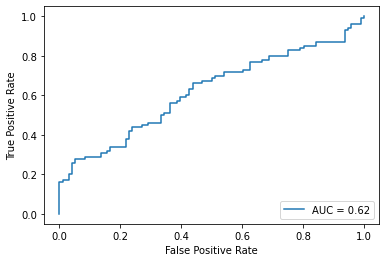

In [56]:
directory = "data/db_data/audio_files_filtered/"
print("calculating labels and scores for given bird song audio files...")
num_file = 1
labels = []
scores = []
# mfccs = {}
use_cc = True
debug_plot = False
sample_rate = 30000


# feature extraction methods
use_mfcc = False
use_mfcc_spafe = False
use_gfcc = True
use_lfcc = False
use_rplp = False
use_lpc = False

num_ceps = 25
num_filters = 40


start_time = time.perf_counter()

for birdsong in os.scandir(directory):

    print("num_file: ", num_file)
    num_file += 1

    if birdsong.is_file():
        # print(birdsong.path)
        filename_str = birdsong.path.split("/")[3].split(".")[0]
        # print(filename)
        filename = filename_str.split("_")
        # print(filename)
        species = filename[0]
        rec_position = filename[1]
        individual = filename[2]
        node = filename[3]
        node_event = filename[4]
        # print(node, node_event)

        file_template = birdsong.path
        # file_template = directory + "/m" + individual + "_" + recording + ".wav"
        # print(file_template)

        for birdsong_query in os.scandir(directory):
            if birdsong_query.is_file():
                # if not (birdsong.path == birdsong_query.path):
                # print("template: ", birdsong.path, ", query: ", birdsong_query.path)
                filename_query_str = birdsong_query.path.split("/")[3].split(".")[0]
                # print(filename)
                filename_query = filename_query_str.split("_")
                # print(filename_query)
                species_query = filename_query[0]
                rec_position_query = filename_query[1]
                individual_query = filename_query[2]
                node_query = filename_query[3]
                node_event_query = filename_query[4]
                # print(node_query, node_event_query)

                # fill in correct labels. 1 if same individual, 0 if different individual
                if (individual == individual_query):
                    labels.append(1)
                else:
                    labels.append(0)

                if (use_cc):
                    # load audios
                    y_1, sr_1 = librosa.load(birdsong.path, sr=sample_rate)
                    y_2, sr_2 = librosa.load(birdsong_query.path, sr=sample_rate)
                    y_1_orig = y_1.copy()
                    y_2_orig = y_2.copy()
                    # cross correlation to match recordings due to imperfect segmentation
                    # shift recording according to highest peak in cc-array
                    cc = scipy.signal.correlate(y_1, y_2, mode='full', method='fft')
                    
                    # get index of peak 
                    peak_index = np.where(cc == np.amax(cc))
                    
                    
                    # shift the shorter audio, otherwise problems may occur
                    if (len(y_1) <= len(y_2)):
                        # get lag array
                        lag_array = scipy.signal.correlation_lags(len(y_1), len(y_2), mode='full')
                        lag = lag_array[np.argmax(cc)]
                        
                        # shift the array according to the lag
                        shifted = scipy.ndimage.interpolation.shift(y_2, lag, mode="constant")
                        y_2 = shifted
                    else:
                        # get lag array
                        lag_array = scipy.signal.correlation_lags(len(y_2), len(y_1), mode='full')
                        lag = lag_array[np.argmax(cc)]
                        
                        # shift the array according to the lag
                        shifted = scipy.ndimage.interpolation.shift(y_1, lag, mode="constant")
                        y_1 = shifted
                        
                    if(debug_plot):
                        # show template and query
                        ax1 = plt.subplot(221)
                        ax1.set_title(f"template: {filename_str}")
                        ax1.plot(y_1_orig)
                        ax2 = plt.subplot(222)
                        ax2.set_title(f"query: {filename_query_str}")
                        ax2.plot(y_2_orig)
                        
                        # show cc array
                        ax3 = plt.subplot(223)
                        ax3.set_title(f"shifted")
                        ax3.plot(shifted)
                        plt.tight_layout()
                        plt.show()
                    
                    
                # TODO Figure out caching with shifted audios
                """ 
                calculate correlation coefficient for every template/ query pair
                to obtain label and score vectors 
                save calculated mfccs for speedup
                """
                # if not args.cc:
                #     if not birdsong.path in mfccs:
                #         mfcc_template = calculateMFCCs(birdsong.path, sr=args.sample_rate)
                #         mfccs[birdsong.path] = mfcc_template
                #     else:
                #         if args.verbose:
                #             print("mfcc already calculated for template: ", birdsong.path)
                #         mfcc_template = mfccs[birdsong.path]
                #     if not birdsong_query.path in mfccs:
                #         mfcc_query = calculateMFCCs(birdsong_query.path, sr=args.sample_rate)
                #         mfccs[birdsong_query.path] = mfcc_query
                #     else: 
                #         if args.verbose:
                #             print("mfcc already calculated for query: ", birdsong_query.path)
                #         mfcc_query = mfccs[birdsong_query.path]
                
                if (use_mfcc):
                    fe_template = librosa.feature.mfcc(y=y_1, sr=sr_1, n_mfcc=num_ceps)
                    fe_query = librosa.feature.mfcc(y=y_2, sr=sr_2, n_mfcc=num_ceps)
                if (use_mfcc_spafe):
                    fe_template = mfcc(sig=y_1, fs=sample_rate, num_ceps=num_ceps, nfilts=num_filters, normalize=0)
                    fe_query = mfcc(sig=y_2, fs=sample_rate, num_ceps=num_ceps, nfilts=num_filters, normalize=0)
                if (use_gfcc):
                    fe_template = gfcc(sig=y_1, fs=sample_rate, num_ceps=num_ceps, nfilts=num_filters)
                    fe_query = gfcc(sig=y_2, fs=sample_rate, num_ceps=num_ceps, nfilts=num_filters)
                if (use_lfcc):
                    fe_template = lfcc(sig=y_1, fs=sample_rate, num_ceps=num_ceps, nfilts=num_filters)
                    fe_query = lfcc(sig=y_2, fs=sample_rate, num_ceps=num_ceps, nfilts=num_filters)
                if (use_rplp):
                    # appears to not be able to differentiate between individuals
                    fe_template = rplp(sig=y_1, fs=sample_rate, num_ceps=num_ceps, normalize=0)
                    fe_query = rplp(sig=y_2, fs=sample_rate, num_ceps=num_ceps, normalize=0)
                if (use_lpc):
                    fe_template = lpc(sig=y_1, fs=sample_rate, num_ceps=num_ceps)
                    fe_query = lpc(sig=y_2, fs=sample_rate, num_ceps=num_ceps)
                    
                # mfcc_query has apparently NaN and infs values due to shifting
                # reason: query audio is way longer, therefore it can happen that shifted audio is just Null
                # solution: shift the shorter audio
                # mfcc_query = ma.masked_invalid(mfcc_query)
                try:
                    score = calculateScore(num_ceps, fe_query, fe_template)
                    scores.append(score)
                except ValueError:
                    print(f"lag: {lag}")
                    print(f"lag (s): {lag/sr_2}")
                    ax1 = plt.subplot(221)
                    ax1.set_title(f"template: {birdsong.path}")
                    ax1.plot(y_1)
                    ax2 = plt.subplot(222)
                    ax2.set_title(f"query: {birdsong_query.path}")
                    ax2.plot(y_2)
                    
                    # show cc array
                    ax3 = plt.subplot(223)
                    ax3.set_title(f"shifted")
                    ax3.plot(shifted)
                    plt.tight_layout()
                    plt.show()

# print(labels)

end_time = time.perf_counter()
print(f"calculation took {end_time - start_time:0.4f} seconds")

fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
roc_auc = metrics.auc(fpr, tpr)
# print(fpr)
# print(tpr)
# print(f"Thresholds: \n {thresholds} ")
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
# print(labels)
# plt.plot(labels)
# plt.plot(scores)
# plt.show()
